In [ ]:
# Import the necessary dependencies

# Operating System
import os
import gc

# Numpy, Pandas and Scipy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler

# Surprise
from surprise import SVD
from surprise import Dataset as sDataset
from surprise import Reader

# Model Evaluation
from evaluation import evaluate_solution

# RAM control
from ramcontrol import check_memory_limit, memory_circuit_breaker

# other 
from utils import create_R_csr_matrix

%matplotlib inline

In [ ]:
# LightFM
from lightfm import LightFM
from lightfm.data import Dataset as lfmDataset 

In [ ]:
# limit of total memory percentage that be used [0.,100.]
memory_limit_perc = 90.

## Step -1: Avaliable data


In [ ]:
submission_file_name = "submission_2"

folder = 'data'

file_data = 'ratings.csv'
path_interactions=os.path.join(folder,file_data)

file_item_attributes = 'anime.csv'
path_item_attributes = os.path.join(folder,file_item_attributes)

file_test_user = 'test_users.csv' 
path_test_user = os.path.join(folder, file_test_user)

In [ ]:
!head -n 2 $path_interactions

user_id,anime_id,rating
32605,31859,7


In [ ]:
!wc -l $path_interactions

4688237 data/ratings.csv


In [ ]:
!head -n 4 $path_item_attributes

anime_id,name,genre,type,episodes,rating,members
1535,Death Note,"Mystery, Police, Psychological, Supernatural, Thriller",TV,37,8.71,1013917.0
16498,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229.0
11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100.0


In [ ]:
!wc -l $path_item_attributes

12295 data/anime.csv


In [ ]:
!head -n 3 $path_test_user

user_id
1497
1530


In [ ]:
!wc -l $path_test_user

132 data/test_users.csv


## Step 0: Load the Data
After validating that the data we have is good enough, we start with building the ratings matrix. Our strategy for the first model is to get a non-personalized system as a baseline. This allows us to both predict for existing users (no cold-start problem) and for new users.

## Step 0.1: Load the interaction file

In [ ]:
data = pd.read_csv(path_interactions)
data.head()


,user_id,anime_id,rating
0,32605,31859,7
1,33399,12291,10
2,44762,9253,10
3,67963,11759,9
4,14343,2116,9


In [ ]:
# change ratings matrix column names to ['user_id','item_id', 'rating']
data_columns = data.columns.to_numpy()
data_columns[1] = 'item_id'
data.columns = data_columns
data.head(2)

,user_id,item_id,rating
0,32605,31859,7
1,33399,12291,10


## Step 0.2: Load item attributes file

In [ ]:
data_items = pd.read_csv(path_item_attributes)
data_items.head(2)

,anime_id,name,genre,type,episodes,rating,members
0,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917.0
1,16498,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229.0


## Step 0.3: Load test users file

In [ ]:
test_users = pd.read_csv(path_test_user)
test_users.head(2)

,user_id
0,1497
1,1530


It will be useful later on to have a list of test data users:

In [ ]:
users_test = list(test_users["user_id"].unique())
print(f"We are recommending recipes for {len(users_test)} users.")

We are recommending recipes for 131 users.


## Step 1: Interaction data exploration

Let's explore the interaction data.

In [ ]:
# How many ratings do we have in total?
# Tip: The ":," at the end of the f-string adds the thousand separator.
data_size = len(data)
print(f"We have {data_size:,} ratings in total.")

We have 4,688,236 ratings in total.


In [ ]:
# How many items were rated?
n_items = data['item_id'].unique().size
print(f" We have {n_items:,} items rated.")

 We have 10,540 items rated.


In [ ]:
# How many users rated at least one item?
m_users = data['user_id'].unique().size
print(f" We have {m_users:,} users that rated at least one item.")

 We have 72,198 users that rated at least one item.


In [ ]:
# How many elements has the dense matrix? 
print(f" We have {m_users*n_items:,} elements in the dense matrix.")

 We have 760,966,920 elements in the dense matrix.


Let's calculate matrix density: 

In [ ]:
density = data_size / (m_users*n_items)
density

0.0061608933013803015

Let's plot the rating distribution:

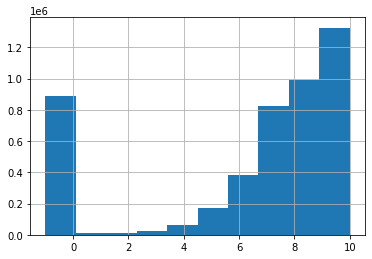

In [ ]:
# Plotting the rating distribution.
data["rating"].hist();

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4688236 entries, 0 to 4688235
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   item_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 107.3 MB


In [ ]:
data.isna().sum()

user_id    0
item_id    0
rating     0
dtype: int64

In [ ]:
# Removing Unexpected Rating Value -1 
nr_reviews_orig = data.shape[0]

data = data.copy().loc[(data["rating"] != -1)]

nr_reviews_new = data.shape[0]

print(f"{nr_reviews_orig - nr_reviews_new:,} reviews with rating -1 where removed from training data of {nr_reviews_orig:,}.")

886,748 reviews with rating -1 where removed from training data of 4,688,236.


In [ ]:
info = data.groupby('item_id')['rating'].mean().reset_index()

In [ ]:
info.merge(data_items, how = 'left', left_on = 'item_id', right_on = 'anime_id')[['anime_id', 'rating_x', 'rating_y']]

,anime_id,rating_x,rating_y
0,1,8.863311,8.82
1,5,8.439826,8.40
2,6,8.415445,8.32
3,7,7.514897,7.36
4,8,7.092784,7.06
...,...,...,...
9512,34324,5.333333,5.40
9513,34325,7.500000,7.05
9514,34349,6.000000,7.25
9515,34367,5.000000,5.97


## Train/Validation Split

We are splitting the available data into training and validation data. The validation data can be used to compare models before submitting the recommendations to the portal.

In [ ]:
data_train, data_val = train_test_split(data, test_size=0.4, random_state=123)

### Training Set

In [ ]:
# How many ratings do we have in total?
# Tip: The ":," at the end of the f-string adds the thousand separator.
print(f"We have {len(data_train):,} ratings in total.")

We have 2,280,892 ratings in total.


In [ ]:
# How many recipes were rated?
print(f" We have {data_train['item_id'].unique().size:,} items rated.")

 We have 9,060 items rated.


In [ ]:
# How many users rated at least one recipe?
print(f" We have {data_train['user_id'].unique().size:,} users that rated at least one item.")

 We have 65,563 users that rated at least one item.


### Validation Set

In [ ]:
# How many ratings do we have in total?
# Tip: The ":," at the end of the f-string adds the thousand separator.
print(f"We have {len(data_val):,} ratings in total.")

We have 1,520,596 ratings in total.


In [ ]:
# How many recipes were rated?
print(f" We have {data_val['item_id'].unique().size:,} items rated.")

 We have 8,649 items rated.


In [ ]:
# How many users rated at least one recipe?
print(f" We have {data_val['user_id'].unique().size:,} users that rated at least one item.")

 We have 63,462 users that rated at least one item.


To be able to compare our recommendations with actual most liked items we need to find users that have enough actual ratings to compare with. If we are measuring `map@k` with `k=50`, users must have at least 50 actual prefered items and we have to provide at least 50 recommendations. One might argue that we now have selection bias because we are specifically selecting users that have more ratings and ignoring users with fewer ratings. This is a consideration that you should take into account specially if you want to evaluate the performance of recommendations to new users. 

Here we are selecting all ratings from users with at least 50 positive reviews as our validation data.

#### Select reviews from users with at least 50 positive ratings.

In [ ]:
def select_frequent_reviewers(df: pd.DataFrame, min_nr_reviews: int = 50, min_rating: int = 5):
    """
    Select reviews from users with at least min_nr_reviews reviews with rating larger than min_rating.
    """
    
    # Select only positive reviews
    df_positive = df.copy().loc[df["rating"] >= min_rating]

    # Select users with more than min_nr_reviews positive reviews
    user_review_count = df_positive.groupby(by=["user_id"])["item_id"].count()
    test_users_list = list(user_review_count[user_review_count > min_nr_reviews].index)

    # Select ratings from users specified above
    df_restrict = df_positive.copy().loc[df_positive["user_id"].isin(test_users_list)]
    
    return df_restrict

data_val_final = select_frequent_reviewers(data_val)
data_val_final.head()

,user_id,item_id,rating
1749687,25440,168,8
823693,27884,12729,8
1502354,63800,10418,7
1565376,56500,16934,8
3336193,61409,10092,8


It will be useful later on to have a list of validation data users:

In [ ]:
users_val = data_val_final["user_id"].unique().tolist()
print(f"We are validating recommendations with {len(users_val)} users.")

We are validating recommendations with 7762 users.


Notice that, even thought we selected 40% of the data to be used for validation, are left with a tiny number of users to validate our results. The validation data is too small to have a accurate evaluation of the models. With more data and a more robust cross-validation method this shouldn't be a problem. 

Beside the new validation users, we also want the validation predictions to compare our results with. 

####  Create the validation recommendations

We will evaluate the outputs of our models with the 50 best rated recipes for each user on the validation data.

In [ ]:
# nr of recommendations per user
k_top = 50

def top_items_per_user(df: pd.DataFrame, user_col: str, rating_col:str, k_top: int = 50):

    df_users_kbest = df.copy().groupby(by=[user_col])[rating_col].nlargest(k_top).reset_index()
    df_users_kbest['rank'] = df_users_kbest.groupby(by=[user_col])[rating_col].rank(method="first")
    #df_users_kbest['rank'] = df_users_kbest['rank'].astype(int) - 1
    # 'level_1': automatic name for index of level 1, created by the groupby method 
    # i.e., values are the index of the original dataframe 
    df_recommendations = df_users_kbest.pivot(index=user_col, columns="rank", values="level_1")
    df_recommendations = df_recommendations.reset_index(drop=False)
    df_recommendations.columns = np.arange(len(df_recommendations.columns))
    # first column (0) is the user id
    # columns 1 to 50 are the index from the original dataframe, 
    # representing the kbest=50 ranked reviews per user 
    return df_recommendations

val_recommendations = top_items_per_user(data_val_final, "user_id", "rating", k_top=k_top)
val_recommendations.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,5,4262333,1649515,1601674,1451575,2291951,1847256,2416072,1370706,3657773,...,892700,193132,3973453,2290358,2463391,2414027,3960142,2707588,2407391,3469498
1,7,1577221,1658819,3800024,214805,3138149,2783723,146601,4487258,1467586,...,4337968,691871,3305490,714229,1885962,4208704,88985,3433021,3861735,3610353
2,17,39036,4522495,4314408,2625766,229659,3979475,2453584,439795,222812,...,2088437,710571,4438306,1329251,958525,4399787,3791937,3865558,2799781,3805005
3,43,519710,1662888,137494,1648752,648345,2617069,3148440,1395024,3695330,...,4384109,2130513,1642650,4024005,2982301,706324,144877,3590526,2474609,1380864
4,46,3637477,264413,266517,3944531,2514008,212952,2494295,289693,3971124,...,2346557,2126228,3166008,903029,471353,313730,1285783,8542,4028879,3083896


#### Saving recommendations

Here we create a function to store the recommendations into a `.csv` file.

In [ ]:
def save_recommendations(df: pd.DataFrame, file_name: str):
    """
    Save recommendation dataframe as .csv.
    """
    
    file_path = os.path.join("data", f"{file_name}.csv")
    df.to_csv(file_path, index=False, header=False)
    print(f"Recommendations were saved on file {file_name}.csv.")
    
save_recommendations(val_recommendations, "validation_recommendations")

Recommendations were saved on file validation_recommendations.csv.


In [ ]:
!head -n 1 data/validation_recommendations.csv

5,4262333,1649515,1601674,1451575,2291951,1847256,2416072,1370706,3657773,3063426,4224336,3799362,603355,2235853,4346571,1981231,1703969,2343675,1871860,1945150,4614605,326577,1008178,3868998,4609336,4682094,733370,3693369,664821,1584435,2724795,4575179,4301061,2132992,4643124,2897822,1456410,1287944,1397916,2586349,892700,193132,3973453,2290358,2463391,2414027,3960142,2707588,2407391,3469498


We now have the "ground-truth" that we are going to use to evaluate our recommendations.

---
# Non-Personalized Recommendations

We can directly find the most popular recipes without creating a rating matrix. We'll consider that the most popular recipes are the ones that have the best score but are also rated more. By calculating the average score and the number of times a recipe was rated, we can sort the recipes and select the best 50.

In [ ]:
def non_pers_reco_order(data: pd.DataFrame,
                        item_col: str,
                        rating_col:str,
                        k_top: int = 50,
                        aggregation: list() = ["mean", "count"]):
    """
    Create an ordered list of non-personalized recommendations, from best rated to worst rated.
    """
    
    non_pers_ratings = data.groupby(by=[item_col])[[rating_col]].agg(aggregation)
    non_pers_ratings.columns = non_pers_ratings.columns.get_level_values(1)

    #The resulting column names might be different than the specified with the aggregation parameter.
    try:
        non_pers_ratings = non_pers_ratings.sort_values(by=aggregation, ascending=False).head(k_top)
    except KeyError as e:
        print(e)
        print("Check if aggregation argument results in valid column names.")
        print(f"aggregation = {aggregation}\nrating columns = {non_pers_ratings.columns}")
        raise e
        
    non_pers_reco_list = non_pers_ratings.index.to_list()
    return non_pers_reco_list


non_pers_recommendations = non_pers_reco_order(data_train, "item_id", "rating", k_top=k_top)
print(non_pers_recommendations)

[9770, 2045, 3131, 3280, 3659, 3823, 3937, 4331, 4640, 4733, 5474, 5535, 5606, 5895, 6579, 6630, 6907, 7245, 8353, 8450, 9900, 11521, 11873, 12039, 12145, 13827, 15961, 16041, 18029, 18047, 19875, 20085, 22477, 22607, 23349, 24071, 27557, 29323, 30743, 32400, 32543, 32563, 33484, 33912, 17092, 28977, 32281, 820, 5520, 5114]


### Output non-personalized solution

Here we create recommendations for the specified users based on the non-personalized recommendations obtained above.

In [ ]:
def non_pers_reco_output(user_id_list:list, non_pers_reco_list:list):
    """
    Creates a non-personalized recommendation dataframe for specified users.
    """
    nr_test_users = len(user_id_list)
    user_id_df = pd.DataFrame(user_id_list, columns = ["user_id"], dtype = int)
    non_pers_reco_repeated =  pd.DataFrame(pd.DataFrame(non_pers_reco_list).T.values.repeat(nr_test_users, axis=0))
    non_pers_reco_output = pd.concat([user_id_df, non_pers_reco_repeated], axis=1)
    
    # Reset columns numbering. Useful later.
    #non_pers_reco_output.columns = np.arange(len(non_pers_reco_output.columns))
    
    return non_pers_reco_output

As you can see we create a recommendation dataframe where each row represents an user and the columns are ordered and numbered from best recommended to least recommended.

For each model and every model, we are going to produce recommendations for the validation set and the test set. So let's start with non-presonalized recommendations.

### Non-personalized recommendations for validation data

We just need to evoke function `non_pers_reco_output` with the validation users and the non-personalized recommendations.

In [ ]:
non_pers_reco_solution_val = non_pers_reco_output(users_val, non_pers_recommendations)
save_recommendations(non_pers_reco_solution_val, "non_personalized_recommendations_VAL")

Recommendations were saved on file non_personalized_recommendations_VAL.csv.


#### Validation evaluation

After creating the output file, we can compare it with the test recommendations. Use function `evaluate_solution` with the solution file name as the first argument and the ground-truth as the second argument.

In [ ]:
## Second argument is the recommendation file to compare
evaluate_solution('non_personalized_recommendations_VAL', 'validation_recommendations')*100

5.7215318971458127e-05

### Non-personalized recommendations for test data

This section simulates the scoring done by the portal. Again, we just need to evoke function `non_pers_reco_output`  but now with the **test** users and the non-personalized recommendations.

In [ ]:
non_pers_recommendations_final = non_pers_reco_order(data, "item_id", "rating", k_top=50)
non_pers_reco_solution_test_final = non_pers_reco_output(test_users["user_id"].to_list(), non_pers_recommendations_final)
save_recommendations(non_pers_reco_solution_test_final, submission_file_name)

Recommendations were saved on file submission_2.csv.


# Ratings.csv analysis

In [ ]:
data_items.head()

,anime_id,name,genre,type,episodes,rating,members
0,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917.0
1,16498,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229.0
2,11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100.0
3,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665.0
4,6547,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13,8.39,717796.0


In [ ]:
data_items_copy = data_items.copy() 
data_items_copy[data_items['members'] > 9e8] = np.nan

In [ ]:
data_items_copy.sort_values(by='members', ascending=False).head(10)

,anime_id,name,genre,type,episodes,rating,members
0,1535.0,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917.0
1,16498.0,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229.0
2,11757.0,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100.0
3,5114.0,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665.0
4,6547.0,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13,8.39,717796.0
6,20.0,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297.0
8,10620.0,Mirai Nikki (TV),"Action, Mystery, Psychological, Shounen, Super...",TV,26,8.07,657190.0
9,4224.0,Toradora!,"Comedy, Romance, School, Slice of Life",TV,25,8.45,633817.0
10,269.0,Bleach,"Action, Comedy, Shounen, Super Power, Supernat...",TV,366,7.95,624055.0
11,226.0,Elfen Lied,"Action, Drama, Horror, Psychological, Romance,...",TV,13,7.85,623511.0


In [ ]:
data_items_copy = data_items_copy[data_items_copy['members']>0.2e6]
data_items_copy.shape

(211, 7)

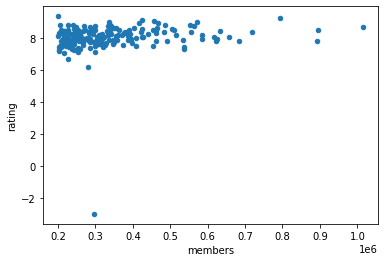

In [ ]:
data_items_copy.plot.scatter(x='members', y='rating');

In [ ]:
data_items_copy = data_items_copy[['anime_id','name','rating','members']]
data_items_copy.sort_values(by='members',ascending=False, inplace=True)
data_items_copy.head(10)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,anime_id,name,rating,members
0,1535.0,Death Note,8.71,1013917.0
1,16498.0,Shingeki no Kyojin,8.54,896229.0
2,11757.0,Sword Art Online,7.83,893100.0
3,5114.0,Fullmetal Alchemist: Brotherhood,9.26,793665.0
4,6547.0,Angel Beats!,8.39,717796.0
6,20.0,Naruto,7.81,683297.0
8,10620.0,Mirai Nikki (TV),8.07,657190.0
9,4224.0,Toradora!,8.45,633817.0
10,269.0,Bleach,7.95,624055.0
11,226.0,Elfen Lied,7.85,623511.0


In [ ]:
anime_ids = list(data_items_copy['anime_id'].astype(int)[:50])
anime_ids

[1535,
 16498,
 11757,
 5114,
 6547,
 20,
 10620,
 4224,
 269,
 226,
 22319,
 19815,
 121,
 6702,
 9919,
 3588,
 2904,
 2001,
 6746,
 30276,
 21881,
 8074,
 11111,
 20507,
 13601,
 21,
 22199,
 1,
 5081,
 199,
 9989,
 9756,
 30,
 10793,
 4181,
 10087,
 6880,
 2025,
 849,
 11061,
 22535,
 4898,
 853,
 23273,
 15809,
 27899,
 31043,
 11617,
 14741,
 7054]

In [ ]:
non_pers_reco_solution_val = non_pers_reco_output(users_val, anime_ids)
save_recommendations(non_pers_reco_solution_val, "validation_recommendations_2")

Recommendations were saved on file validation_recommendations_2.csv.


In [ ]:
evaluate_solution('validation_recommendations_2', 'validation_recommendations')*100

0.00011178742803170098

In [ ]:
non_pers_reco_solution_val = non_pers_reco_output(users_test, anime_ids)
save_recommendations(non_pers_reco_solution_val, "submission_2")

Recommendations were saved on file submission_2.csv.


In [ ]:
pd.read_csv('/work/Hackathon05/data/submission_2.csv', header=None)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,1497,1535,16498,11757,5114,6547,20,10620,4224,269,...,22535,4898,853,23273,15809,27899,31043,11617,14741,7054
1,1530,1535,16498,11757,5114,6547,20,10620,4224,269,...,22535,4898,853,23273,15809,27899,31043,11617,14741,7054
2,2951,1535,16498,11757,5114,6547,20,10620,4224,269,...,22535,4898,853,23273,15809,27899,31043,11617,14741,7054
3,5310,1535,16498,11757,5114,6547,20,10620,4224,269,...,22535,4898,853,23273,15809,27899,31043,11617,14741,7054
4,5908,1535,16498,11757,5114,6547,20,10620,4224,269,...,22535,4898,853,23273,15809,27899,31043,11617,14741,7054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,67296,1535,16498,11757,5114,6547,20,10620,4224,269,...,22535,4898,853,23273,15809,27899,31043,11617,14741,7054
127,67348,1535,16498,11757,5114,6547,20,10620,4224,269,...,22535,4898,853,23273,15809,27899,31043,11617,14741,7054
128,67666,1535,16498,11757,5114,6547,20,10620,4224,269,...,22535,4898,853,23273,15809,27899,31043,11617,14741,7054
129,68084,1535,16498,11757,5114,6547,20,10620,4224,269,...,22535,4898,853,23273,15809,27899,31043,11617,14741,7054


---
# Collaborative filtering

Now that we have a baseline model, we can try collaborative filtering.
We are going to use some open-source libraries to replicate what we did on the previous SLUs.

The first library that we are going to use is *[LightFM](https://making.lyst.com/lightfm/docs/home.html)*. LightFM allows to create the rating matrix (aka interaction matrix) and use that matrix to generate recommendations for our users.

We start by using lightFM `Dataset()` function to create the user and item mapping that defines the vectorial space of the rating matrix.

In [ ]:
# Notice the alias lfmDataset() instead of the standard Dataset()
# Used to distiguish between lightFM Dataset() and another Dataset() that we use later.
lfmdataset = lfmDataset()
lfmdataset.fit(data_train['user_id'], data_train["item_id"])

We can check that vectorial space is defined as expected:

In [ ]:
num_users, num_items = lfmdataset.interactions_shape()
print('Num users: {:,}, num_items {:,}.'.format(num_users, num_items))

Num users: 65,563, num_items 9,060.


The mapping between external user IDs (the ones in our data) and the internal user IDs can be obtained with method `.mapping()`. The same applies for items.

In [ ]:
user_id_map, user_feature_map, item_id_map, item_feature_map = lfmdataset.mapping()

Reverses map between external and internal IDs. This is used to get the original IDs from the internal IDs.

In [ ]:
item_id_map_reverse = {v: k for k, v in item_id_map.items()}

We now need to create the rating matrix. The equivalent in lightFM is the interactions matrix. We use the `build_interactions` to create the interaction matrix in the COOrdinate format. The argument is an iterable of (user_id, item_id) or (user_id, item_id, weight)), where weight is what we call rating.

In [ ]:
(interactions, weights) = lfmdataset.build_interactions((row for row in data_train.values))

print(repr(interactions))

<65563x9060 sparse matrix of type '<class 'numpy.int32'>'
	with 2280892 stored elements in COOrdinate format>


We now define the model that we are going to use to produce our recommendations. We select the `warp` loss function as it is [recommended](https://making.lyst.com/lightfm/docs/lightfm.html#id2) for optimizing to top of recommendation list (precision@k), which is our case.

In [ ]:
lfmodel = LightFM(loss='warp')

We fit the model with our interaction data.

In [ ]:
lfmodel.fit(interactions)

With the model trained and the dataset in COO format, we can produce recommendations for a given user.

We can use the method `.predict` to calculate the score (rating) of each item for a given user. We then sort the items' IDs in descending order of rating and select the `k_top` best items.

We recommended recipes for one user. It's time to predict for a set of users. We'll repeat the previous process for each user in the set if that user is present in the training data. If the user is not present in the training data then we have to use non-personalized recommendations.

We start by separating the users present in training data and the users absent in the training data:

We then list all the item IDs:

In [ ]:
# list of item external ids
item_id_ext_list = list(item_id_map.values())

In [ ]:
def lightFM_recommendations(dataset,
                            model,
                            user_id_ext_list,
                            non_pers_reco_list,
                            k_top: int = 50,
                            item_features = None):   
    """
    Create output dataframe with recommendations based on dataset, model and list of users.
    
    This function predicts recommendations for users specified in user_id_ext_list that are present in the lightFM dataset.
    New users are recommended the items in the non-personalized list non_per_reco_list.
    
    Parameters:
    -----------
    dataset: lightFM dataset
    
    model: lightFM trained model
    
    user_id_ext_list: list of user external IDs to predict
    
    non_pers_reco: list of non-personalized recommendations ordered from best to worst rated
    
    k_top: number of recommendations to create per user
    
    item_features: lightFM item features
    
    Returns:
    --------
    final_reco_df: dataframe with users' recommendations
    The first column has the users' ID and the remaining columns have the recommendations
    """
    
    assert len(user_id_ext_list) > 0, "User ID list length must be larger than 0."
    
    # Dataset mappings
    user_id_map, user_feature_map, item_id_map, item_feature_map = dataset.mapping()
    
    # reverse mapping
    item_id_map_reverse = {v: k for k, v in item_id_map.items()}
    user_id_map_reverse = {v: k for k, v in user_id_map.items()}
    
    
    # item internal ids
    item_id_int_list = list(item_id_map.values())
    
    # Split old users (user_id_int_list) from new users (user_id_ext_excluded)
    # Old users are defined in the ratings vectorial space.
    # New users are not defined in the ratings vectorial space.
    # New users receive non-personalized recommendations.
    user_id_int_list = []
    user_id_ext_excluded = []
    
    for user_id_ext in user_id_ext_list:
        try:
            user_id_int_list.append(user_id_map[user_id_ext])
        except:
            user_id_ext_excluded.append(user_id_ext)
            print(user_id_ext)
    
    # Dataframe to store model recommendations
    model_reco_df = pd.DataFrame()
    
    # Model recommendations
    for user_id in user_id_int_list:
        scores = model.predict(user_id, item_id_int_list, item_features)
        top_items_ids = np.argsort(-scores)
        top_items_ids = [item_id_map_reverse[ids] for ids in top_items_ids]
         
        # Individual row. Two steps are necessary for the first row to call "user_id"
        user_id_df = pd.DataFrame([user_id_map_reverse[user_id]], columns=["user_id"], dtype = int)
        top_items_ids = pd.DataFrame([top_items_ids[:k_top]])
        user_reco_df = pd.concat([user_id_df, top_items_ids], axis=1)
        
        # Concatenating rows
        model_reco_df = pd.concat([model_reco_df, user_reco_df])
        
        # Stop execution if memory is almost full
        memory_circuit_breaker(memory_limit_perc)
        
        
    # Non-personalized recommendations
    non_pers_reco_df = non_pers_reco_output(user_id_ext_excluded, non_pers_reco_list)
    
    # Concatenating all recommendations
    if model_reco_df.shape[0] == 0:
        final_reco_df = non_pers_reco_df
    elif non_pers_reco_df.shape[0] == 0:
        final_reco_df = model_reco_df
    else:
        final_reco_df = pd.concat([model_reco_df, non_pers_reco_df])
    
    return final_reco_df

### Let's test with a couple of users

In the example below the user 123213231 is a new user so it should receive the non-personalized recommendations. The remaining users already exist on the training data so the model should output collaborative-based recommendations.

### Collaborative filtering recommendations for validation data

Now that we checked that `lightFM_recommendations` creates recommendations for the provided users, we create the recommendations for the validations users, store them in a `.csv` file and evaluate the results.

In [ ]:
collab_reco_val = lightFM_recommendations(lfmdataset, lfmodel, users_val, anime_ids, k_top=50)
save_recommendations(collab_reco_val, "recommendations_VAL_lightfm")

Recommendations were saved on file recommendations_VAL_lightfm.csv.


#### Validation evaluation

In [ ]:
evaluate_solution('recommendations_VAL_lightfm', 'validation_recommendations')*100

0.0003217651157147592

### Collaborative filtering recommendations for test data

The same can be performed for the test data.

In [ ]:
# Notice the alias lfmDataset() instead of the standard Dataset()
# Used to distiguish between lightFM Dataset() and another Dataset() that we use later.
lfmdataset_full = lfmDataset()
lfmdataset_full.fit(data['user_id'], data["item_id"])

user_id_map_full, user_feature_map_full, item_id_map_full, item_feature_map_full = lfmdataset_full.mapping()

item_id_map_reverse_full = {v: k for k, v in item_id_map_full.items()}

(interactions_full, weights_full) = lfmdataset_full.build_interactions((row for row in data.values))


lfmodel_full = LightFM(loss='warp')
lfmodel_full.fit(interactions_full)

# item_id_ext_list = list(item_id_map_full.values())

In [ ]:
collab_reco_test = lightFM_recommendations(lfmdataset_full, lfmodel_full, users_test, anime_ids, k_top=50)
save_recommendations(collab_reco_test, "submission_3")

Recommendations were saved on file submission_3.csv.


In [ ]:
pd.read_csv("data/submission_3.csv", header=None)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,1497,11757,19815,16498,6547,14813,20507,15809,14741,10620,...,10793,20787,2167,13659,14345,22535,8525,4181,28171,23283
1,1530,11757,16498,19815,10620,9253,22319,5114,30276,6547,...,9756,31043,23273,11617,23289,11633,8769,22297,18153,14513
2,2951,11757,10719,19815,6547,16498,14813,15809,9253,8769,...,30276,15451,4181,9989,10087,2904,23273,10790,13601,28121
3,5310,6547,10719,8769,11757,14813,5081,8525,9253,14741,...,9989,2904,22199,6213,10087,14833,19221,9756,11759,15689
4,5908,199,205,431,121,1535,30,164,853,226,...,4898,5114,72,572,356,1210,2759,457,1689,237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,67296,849,226,2966,30,5081,2001,2904,889,2759,...,43,2236,270,32,1195,9756,4382,2593,5630,73
127,67348,6547,11757,4224,9253,5081,8769,16498,2167,8074,...,8675,10087,9919,9041,20507,1840,17265,14345,11741,6880
128,67666,6547,11757,10719,14813,8769,4224,19815,5081,15809,...,15315,14345,11111,23289,226,23273,1195,21881,14833,20787
129,68084,11757,16498,19815,30276,9253,20507,22319,13601,10620,...,12189,8074,10719,28121,2904,15689,9919,18897,13759,11597


#### Clean up

To save some RAM, we are removing some objects that won't be needed later. If you want to keep them, comment the next cell.

In [ ]:
''' del (interactions,
    non_pers_reco_solution_val,
    # non_pers_reco_solution_test,
    model_reco_df,
    final_reco_df,
    collab_reco_val,
    collab_reco_test)
gc.collect()
'''
''

''

---
# Content-based Recommendations

We are going to create recommendations that take into account the recipes information. We will use a `lightFM` model and introduce the recipe (item) information. We will explore the recipe information, identify potentially useful features and process some of them to use in the model.

### enconding genre 

In [ ]:
# Explode the genres into columns
data_items['genre'] = data_items['genre'].str.lower().str.split(',')
genres_exploded = data_items['genre'].explode()

# Do one-hot encoding of the columns
genre_encoding = data_items[['anime_id']].join(pd.crosstab(genres_exploded.index, genres_exploded))
genre_encoding = genre_encoding.fillna(0)
genre_encoding.head()

,anime_id,adventure,cars,comedy,dementia,demons,drama,ecchi,fantasy,game,...,shoujo,shounen,slice of life,space,sports,super power,supernatural,thriller,vampire,yaoi
0,1535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,16498,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11757,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5114,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6547,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 

In [ ]:
### enconding type 

In [ ]:
type_encoding = pd.merge(data_items['anime_id'], pd.get_dummies(data_items.type), left_index = True, right_index = True)
type_encoding.head()

,anime_id,Movie,Music,ONA,OVA,Special,TV
0,1535,0,0,0,0,0,1
1,16498,0,0,0,0,0,1
2,11757,0,0,0,0,0,1
3,5114,0,0,0,0,0,1
4,6547,0,0,0,0,0,1


In [ ]:
genre_encoding = genre_encoding[genre_encoding.columns[genre_encoding.sum() > 1]]
genre_encoding.head()

,anime_id,adventure,cars,comedy,dementia,demons,drama,ecchi,fantasy,game,...,samurai,school,sci-fi,seinen,shoujo,shounen,slice of life,sports,supernatural,yaoi
0,1535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,16498,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11757,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5114,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6547,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
anime_features = genre_encoding.merge(type_encoding, left_on = 'anime_id', right_on = 'anime_id').set_index('anime_id', drop = True)
anime_features.head()

,adventure,cars,comedy,dementia,demons,drama,ecchi,fantasy,game,harem,...,slice of life,sports,supernatural,yaoi,Movie,Music,ONA,OVA,Special,TV
anime_id,,,,,,,,,,,,,,,,,,,,,
1535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,1
16498,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,1
11757,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,1
5114,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,1
6547,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,1


### Members

In [ ]:
data_items.head()

,anime_id,name,genre,type,episodes,rating,members
0,1535,Death Note,"[mystery, police, psychological, supernatur...",TV,37,8.71,1013917.0
1,16498,Shingeki no Kyojin,"[action, drama, fantasy, shounen, super po...",TV,25,8.54,896229.0
2,11757,Sword Art Online,"[action, adventure, fantasy, game, romance]",TV,25,7.83,893100.0
3,5114,Fullmetal Alchemist: Brotherhood,"[action, adventure, drama, fantasy, magic,...",TV,64,9.26,793665.0
4,6547,Angel Beats!,"[action, comedy, drama, school, supernatural]",TV,13,8.39,717796.0


In [ ]:
members_data = data_items[["anime_id", "members"]]

In [ ]:
members_data[members_data["members"] > 500000000]

,anime_id,members
904,24227,999999999.0
1348,6574,999999999.0
1701,1810,999999999.0
5345,3051,999999999.0
5509,21349,999999999.0
5604,2834,999999999.0
5757,3248,999999999.0
6676,2977,999999999.0
6957,5136,999999999.0
7759,2310,999999999.0


In [ ]:
reasonable_members_data = members_data[members_data["members"] < 999999999]

In [ ]:
reasonable_members_data["members"].median()

1551.0

In [ ]:
reasonable_members_data["members"].mean()

17888.33772652389

In [ ]:
members_data["worked_members"] = members_data["members"]

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
members_data.loc[members_data["worked_members"]== 999999999, 'worked_members'] = 1551

/root/venv/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
members_data.head()

,anime_id,members,worked_members
904,24227,999999999.0,999999999.0
1348,6574,999999999.0,999999999.0
1701,1810,999999999.0,999999999.0
5345,3051,999999999.0,999999999.0
5509,21349,999999999.0,999999999.0


In [ ]:
members_data[members_data["worked_members"] > 500000000]

,anime_id,members,worked_members


In [ ]:
members_data[members_data["worked_members"] < 0]

,anime_id,members,worked_members


In [ ]:
team_scaler = RobustScaler()

In [ ]:
members_data["worked_members"] = team_scaler.fit_transform(members_data[["worked_members"]])

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:ylabel='Frequency'>

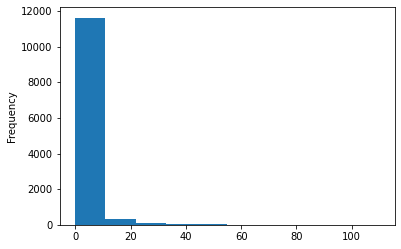

In [ ]:
members_data['worked_members'].plot.hist()

In [ ]:
members_data.head()

,anime_id,members,worked_members
0,1535,1013917.0,109.956120
1,16498,896229.0,97.173672
2,11757,893100.0,96.833822
3,5114,793665.0,86.033887
4,6547,717796.0,77.793527


In [ ]:
anime_features_2 = members_data[['anime_id', 'worked_members']].set_index("anime_id", drop = True)

In [ ]:
anime_features_2.head()

,worked_members
anime_id,
1535,109.956120
16498,97.173672
11757,96.833822
5114,86.033887
6547,77.793527


In [ ]:
anime_generator = anime_features_2.itertuples(index=True, name=None)

content_dataset = lfmDataset()
content_dataset.fit(data['user_id'], data["item_id"], item_features=anime_generator)

item_features = content_dataset.build_item_features(anime_generator)
(interactions, weights) = content_dataset.build_interactions((row for row in data.values))

content_model = LightFM(loss='warp')
content_model.fit(interactions, item_features=item_features)

content_reco_val = lightFM_recommendations(content_dataset,
                                           content_model,
                                           users_test,
                                           non_pers_recommendations,
                                           k_top=50,
                                           item_features = item_features)

save_recommendations(content_reco_val, "submission_5_test")

Recommendations were saved on file submission_5_test.csv.


In [ ]:
pd.read_csv("/work/Hackathon05/data/submission_5_test.csv")

,1497,19815,15583,14741,11757,13759,14813,10719,18897,21881,...,18679,8769,11597,20785,5081,9919,9253,26243,19163,23847
0,1530,11757,6547,16498,19815,14741,5081,13759,8841,10793,...,10087,15451,8675,22199,3455,6347,14967,30276,13659,1575
1,2951,11757,6547,19815,11617,14741,16498,10719,5081,13759,...,18679,4654,22199,14967,8675,8937,9989,11499,15315,5114
2,5310,5081,6547,8769,10719,10080,11757,14741,3455,8841,...,14967,11499,4181,9919,9989,10087,6880,11759,8630,18679
3,5908,30,121,1,270,1575,1818,6,1535,164,...,32,934,2966,47,202,44,5114,57,2251,1887
4,6417,121,1575,849,71,30,59,226,2904,889,...,47,5680,430,20,245,195,24,225,857,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,67296,1575,2904,849,226,1535,2167,121,30,6547,...,199,355,813,5630,8769,164,1840,73,11757,9756
126,67348,5081,6547,3455,8769,8841,10719,10080,4224,4654,...,4181,4214,11111,8516,6213,8630,10620,19815,6880,13659
127,67666,10719,14741,5081,11757,6547,19815,13759,8769,11617,...,18671,18679,15451,20787,4654,11759,21881,11499,2167,7593
128,68084,11757,6547,19815,16498,14741,10793,11617,5081,8074,...,1575,14345,11597,11741,15451,30276,6347,226,13601,8675


In [ ]:
evaluate_solution('submission_5', 'validation_recommendations')*100

0.0002989480375384492

In [ ]:
data_train.head()

,user_id,item_id,rating
1498424,69723,23037,6
933954,39477,28999,6
1357991,30895,11285,8
1616850,11132,687,8
4677917,52071,617,8


In [ ]:
content_reco_val = lightFM_recommendations(content_dataset,
                                           content_model,
                                           users_val,
                                           non_pers_recommendations,
                                           k_top=k_top,
                                           item_features = item_features)
save_recommendations(content_reco_val, "content_recommendations_VAL")

Recommendations were saved on file content_recommendations_VAL.csv.


#### Validation evaluation

In [ ]:
evaluate_solution('content_recommendations_VAL', 'validation_recommendations')

0.0001397819401733296

### Content-based recommendations for test data

In [ ]:
content_reco_test = lightFM_recommendations(content_dataset,
                                            content_model,
                                            users_test,
                                            non_pers_recommendations,
                                            k_top=k_top,
                                            item_features = item_features)
save_recommendations(content_reco_test, "content_recommendations_TEST")

Recommendations were saved on file content_recommendations_TEST.csv.


#### Test evaluation

In [ ]:
evaluate_solution('content_recommendations_TEST')

2.9477776351790893e-06

#### Clean up

In [ ]:
del (recipes_rescale,
     recipes_encoding,
     recipe_features_df,
     interactions,
     recipe_generator,
     content_dataset,
     content_model,
     content_reco_val,
     content_reco_test)
gc.collect()

20

---

# Collaborative recommendations with Surprise

[Surprise](http://surpriselib.com/) is a [SciKit](https://www.scipy.org/scikits.html), i.e. an add-on package for SciPy, that can be use to build recommender systems for explicit rating data. It doesn't support content-based information though.

We start by preparing the data and the loader. These will be use by method `load_from_df` to load the data into a dataset object. The dataframe to be loaded **must specifically** have the columns `userID`, `itemID` and `rating`. Because of this, we need to rename our columns.

In [ ]:
data_train_surprise = data_train.copy().rename(columns={"user_id":"userID", "item_id":"itemID"})

# a reader is required in load_from_df
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data_surprise = sDataset.load_from_df(data_train_surprise[['userID', 'itemID', 'rating']], reader)
data_surprise

Since we already split the data intro training and validation, we can use all training data as the train set. You can use all data for training with method `build_full_trainset()`. If wanted to split you data with `Surprise`, you could use function [`train_test_split`](https://surprise.readthedocs.io/en/stable/getting_started.html#train-test-split-and-the-fit-method) or with some [cross-validations strategies](https://surprise.readthedocs.io/en/stable/model_selection.html#cross-validation-iterators-api).

In [ ]:
# Retrieve the trainset.
trainset = data_surprise.build_full_trainset()

#### Model

One of the available `Surprise` models is the [`KNNBasic`](https://surprise.readthedocs.io/en/stable/knn_inspired.html) model. This a basic collaborative filtering algorithm. We could say it's an improved version of the algorithm that we developed on BLU10. One issue with this model is that the similarity matrixes generated while training the model are not sparse, but dense. This means that, even for moderately large datasets, the model will use gigabytes of memory which isn't feasible for most consumer PCs.

As an alternative, will use the [`SVD`](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD) which is based on matrix factorization to approximate the rating matrix using lower ranking matrixes. [Here's](https://cs.carleton.edu/cs_comps/0607/recommend/recommender/svd.html) a brief summary of usage of SVD. `Surprise's SVD` use stochastic gradient descent to minimize the error between the estimated rating matrix and the actual rating matrix during training.

In [ ]:
svdmodel = SVD(random_state=123)
svdmodel.fit(trainset)

#### Generate all user/item combinations

To make recommendations using the Surprise module, we need to provide the `.predict` method of the model with the user ID / item ID pair of which we want the rating. After having the rating all of items for a given user, we can order the best rated items and select the best to recommend.

The steps followed in the next cell are:

1. Select the users that we want to recommend to.
2. Create 3 lists: one to place user IDs, one to place item IDs and another to place the respective rating. The lists are created empty with size `nr. users * nr. items` to allocate all user/item combinations.
3. For each user/item combination, predict rating.
4. Store user id, item id and rating on increasing indexes on the list.

In [ ]:
# select a few users
users_surprise = [1232131231, 1498649, 99136, 83961]

recipe_ids = recipes["id"].unique()

# calculate the list size beforehand 
test_total_len = len(users_surprise) * len(recipe_ids)

# to avoid appending lists
user_id_pred = [None] * test_total_len
recipe_id_pred = [None] * test_total_len
rating_pred = [None] * test_total_len

index_counter = 0
for user in users_surprise:
    for recipe in recipe_ids:
        
        prediction = svdmodel.predict(user, recipe)
        user_id_pred[index_counter] = prediction.uid
        recipe_id_pred[index_counter] = prediction.iid
        rating_pred[index_counter] = prediction.est
        
        index_counter += 1

From the lists above we can build a predictive rating dataframe to then select best 50 items per user.

In [ ]:
collab_pred_dict = {'item_id': recipe_id_pred,
                'user_id': user_id_pred,
                'rating': rating_pred}
collab_pred_df = pd.DataFrame(collab_pred_dict)
collab_pred_df.head()

,item_id,user_id,rating
0,70971,1232131231,4.695461
1,75452,1232131231,4.724772
2,42198,1232131231,4.724308
3,67547,1232131231,4.649798
4,23933,1232131231,4.728331


#### Selecting top recommendations

We now use the function that we defined earlier to select the best k recommendations for each user.

In [ ]:
val_collab_recommendations = top_items_per_user(collab_pred_df, "user_id", "rating")
val_collab_recommendations

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,83961,115923,116103,116501,117153,117629,118309,118386,118424,118639,...,131216,131285,131443,131468,131566,131994,132102,132351,132441,132553
1,99136,85786,109358,95151,110532,114685,94125,86342,78155,96658,...,88617,80003,114605,94995,103253,108686,110264,100025,83292,97146
2,1498649,47150,70722,56515,71896,76049,55489,47706,39519,58022,...,49981,41367,75969,56359,64617,70050,71628,61389,44656,58510
3,1232131231,8514,32086,17879,33260,37413,16853,9070,883,19386,...,11345,2731,37333,17723,25981,31414,32992,22753,6020,19874


We now bave recommendations using the `Surprise` package!

We can generalize this whole process with a function.

In [ ]:
def surprise_recommendations(data,
                            model,
                            user_id_ext_list,
                            item_id_ext_list,
                            k_top: int = 50,
                            columns_dict: dict = {"user_id":"userID", "item_id":"itemID"}):    
    """
    Create output dataframe with recommendations based on dataset, Surprise model, list of users and list of items.
    
    This function produces recommendations for users specified in user_id_ext_list
    
    
    
    
    Parameters:
    -----------
    data: dataframe with ratings for each user-item pair
    
    model: untrained Surprise model
    
    user_id_ext_list: list of user external IDs to predict
    
    user_id_ext_list: list of item external IDs to predict
    
    k_top: number of recommendations to create per user
    
    columns_dict: dictionary that converts old column names into Surprise compatible names.
    
    Returns:
    --------
    final_reco_df: dataframe with users' recommendations
    The first column has the users' ID and the remaining columns have the recommendations
    """
    
    data_surprise = data.copy().rename(columns= columns_dict)

    # A reader is still needed but only the rating_scale param is required
    reader = Reader(rating_scale=(data_surprise['rating'].min(), data_surprise['rating'].max()))

    # The columns must correspond to user id, item id and ratings (in that order).
    dataset_surprise = sDataset.load_from_df(data_surprise[['userID', 'itemID', 'rating']], reader)

    # Retrieve the trainset
    trainset = dataset_surprise.build_full_trainset()
    
    # fit the model
    model.fit(trainset)
    
    # calculate the list size beforehand 
    total_len_pred = len(user_id_ext_list) * len(item_id_ext_list)

    # to avoid appending lists
    user_id_pred = [None] * total_len_pred
    recipe_id_pred = [None] * total_len_pred
    rating_pred = [None] * total_len_pred

    index_counter = 0
    for user in user_id_ext_list:
        for recipe in item_id_ext_list:

            prediction = model.predict(user, recipe)
            user_id_pred[index_counter] = prediction.uid
            recipe_id_pred[index_counter] = prediction.iid
            rating_pred[index_counter] = prediction.est

            index_counter += 1
            
            # Stop execution if memory is almost full
            memory_circuit_breaker(memory_limit_perc)
    
    model_pred_dict = {'item_id': recipe_id_pred,
                'user_id': user_id_pred,
                'rating': rating_pred}
    model_pred_df = pd.DataFrame(model_pred_dict)
    
    model_recommendations = top_items_per_user(model_pred_df, "user_id", "rating")
    
    return model_recommendations

Let's try with some users.

In [ ]:
users_surprise = [1232131231, 1498649, 99136, 83961]

surprise_recommendations(data_train,
                         SVD(random_state=123),
                         users_surprise,
                         recipes["id"].unique(),
                         k_top)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,83961,115923,116103,116501,117153,117629,118309,118386,118424,118639,...,131216,131285,131443,131468,131566,131994,132102,132351,132441,132553
1,99136,85786,109358,95151,110532,114685,94125,86342,78155,96658,...,88617,80003,114605,94995,103253,108686,110264,100025,83292,97146
2,1498649,47150,70722,56515,71896,76049,55489,47706,39519,58022,...,49981,41367,75969,56359,64617,70050,71628,61389,44656,58510
3,1232131231,8514,32086,17879,33260,37413,16853,9070,883,19386,...,11345,2731,37333,17723,25981,31414,32992,22753,6020,19874


Excellent! We now can recommend recipes for our validation and test users using `surprise_recommendations`, store our results with `save_recommendations` and evaluate our results.

### Collaborative filtering recommendations for validation data (with Surprise)

Unfortunately, the process that we used for a couple of users is not by any means efficient. It takes a lot of time to compute for the validation and test users. If you can parallelize the executions maybe you can run it in useful time. As it stands, it's not recommended to use `Surprise` for anything other than small datasets and a low number of users.

The codes to make the recommendations are below, but are commented.

In [ ]:
#collab_reco_surprise_val = surprise_recommendations(data_train,
#                                                    SVD(random_state=123),
#                                                    users_val,
#                                                    recipes["id"].unique(),
#                                                    k_top)
#save_recommendations(collab_reco_surprise_val, "collaborative_recommendations_surprise_VAL")

#### Validation evaluation

In [ ]:
#evaluate_solution('collaborative_recommendations_surprise_VAL', 'validation_recommendations')

### Collaborative filtering recommendations for test data (with Surprise)

In [ ]:
#collab_reco_surprise_test = surprise_recommendations(data_train,
#                                                     SVD(random_state=123),
#                                                     users_test,
#                                                     recipes["id"].unique(),
#                                                     k_top)
#save_recommendations(collab_reco_surprise_test, "collaborative_recommendations_surprise_TEST")

#### Test evaluation

In [ ]:
#evaluate_solution('collaborative_recommendations_surprise_TEST')

### On new users

New users are given the mean rating for all training data ratings. This will probably be worse than non-personalized recommendations.
As an exercise, modify the previous function (or create a new one) to replace the recommendations for users that we don't have any information.

---

# Model Selection

It's the end of the day and we have to deliver a model. To simplify, we are going to select the model with best score on the validation data. Remember that the test data is hidden. We just use it to simulate the portal.

The `map@50` values of other models are:

Non-personalized recommendations:
- Validation: 0.0
- Test: 4.651674179825267e-06

Collaborative recommendations:
- Validation: 9.318796011555306e-05
- Test: 3.583748452090996e-06

Content-based:
- Validation: 6.98909700866648e-05
- Test: 3.2054271072713093e-06

Based on the validation results, we would select the collaborative-filtering model since it has the largest validation`map@50`.

Later, it's a good idea to automatize the model selection process to compare many more models and parameters.

---
# Next steps

We have successfully trained a couple of recommendation models to recommend recipes to our users!

Your boss is happy... for now. There is still a lot to be done. Just like with other machine learning applications, recommendations models are not a "build once and it's done" kind of deal. We won't go in much detail here because most of these considerations were already discussed on previous learning units. 

Here are a couple of suggestions that you **should** try to implement (on another notebook):

- Cross-validation: Here we have used out-of-sample validation and selected the best model. Try to implement cross-validation using the module's own methods or create your own pipelines.

- Hyperparameter tuning: We haven't performed any hyperparameter tuning on this workflow. Use hyperparameter tuning to explore more models and find better ones.

- Modify code: It feels like some of the examples in this workflow are not to your liking? Then modify them and make them your own. Make changes to simplify your work.

- Other modules: Try to use other recommender systems modules to see if they are simpler to use, give better results or present other advantages. You can check [this GitHub repo](https://github.com/microsoft/recommenders) with a vast selection of recommender system modules with examples. Remember that you should know, to a certain degree, how the model you are using works and what are its limitations.
 
- More data: You can try, with this or another dataset, to gradually introduce data to the model to simulate new data streaming in. Make use of methods that allow to directly fit new data (usually called someting like [fit_partial](https://making.lyst.com/lightfm/docs/lightfm.html#lightfm.LightFM.fit_partial), for example) or batch train your model each time.

- Different data: Practice your modelling skills with other data sets. See what changes you need to carry out when the data has different properties.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=28895d3e-f77b-4bea-951b-700585fed7e2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>